In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
from models import *

In [ ]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
input_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")

In [ ]:
vc = train_df[label_column].value_counts()

In [ ]:
down_sample_vc = vc[vc.values < 1500]
input_df = input_df[input_df[label_column].isin(down_sample_vc.index)]

In [ ]:
running_device = torch.device("cuda")

In [ ]:
prd = ProcessData(input_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")

After removing duplicate sentence: 60385
After drop cpv with low observations we have : 60292
The num of class is  42
The number of total data is:  27937
Total number of test data is:  1260
Total number of train data is:  26677


In [ ]:
vc2 = train_df[label_column].value_counts()
down_sample_vc = vc2[vc2.values >700]
train_df = train_df[train_df[label_column].isin(down_sample_vc.index)]
translate_back=translate_back[translate_back[label_column].isin(down_sample_vc.index)]

In [ ]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)

Getting bert hidden states from layer: 0: 100%|██████████| 900/900 [00:11<00:00, 78.50it/s]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [ ]:
def decide_aug_labels_bunch(balance, aug_limits, value_counts, percents):
    aug_num_dict = {}
    if balance:
        for label in value_counts.index:
            aug_nums = []
            for aug_limit in aug_limits:
                if value_counts[label] < aug_limit:
                    aug_nums.append(aug_limit - value_counts[label])
            aug_num_dict[label] = aug_nums
    else:
        for label in value_counts.index:
            aug_nums = []
            for percent in percents:
                aug_nums.append(int(value_counts[label] * percent))
            aug_num_dict[label] = aug_nums
    return aug_num_dict

In [ ]:
value_counts = train_df[label_column].value_counts()

In [ ]:
aug_limits = decide_aug_labels_bunch(False, None, value_counts,[0.5 + 0.5 * i for i in range(8)])

In [ ]:
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(train_df)
insuf_ds_list = list(insuf_ds_dict.values())
augmented_ds_lists = model_runner.augment_bunch_data(bert, aug_limits,8, insuf_ds_dict)

Getting bert hidden states from layer: 0:  24%|██▍       | 134/548 [00:01<00:05, 81.33it/s]

In [ ]:
ACCs = []
F1s = []
Precisions = []
Recalls = []
Label_f1s = []
for i in range(8):
  train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists[i])
  train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
  classifier = EmbeddingClassifier(prd.num_class, bert)
  classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  ACCs.append(acc)
  F1s.append(f1)
  Precisions.append(precision)
  Recalls.append(recall)
  Label_f1s.append(label_f1)

We have: 30 labels to be augmented


100%|██████████| 1120/1120 [07:43<00:00,  2.42it/s]


0 train loss:  2.5119000167718957 val acc:  0.4177777859899733


100%|██████████| 1120/1120 [07:42<00:00,  2.42it/s]


1 train loss:  1.0756414649875037 val acc:  0.5500000152322981


100%|██████████| 1120/1120 [07:43<00:00,  2.42it/s]


2 train loss:  0.7179197581218821 val acc:  0.5833333472410838


100%|██████████| 1120/1120 [07:42<00:00,  2.42it/s]


3 train loss:  0.5353300992116731 val acc:  0.603333342075348


100%|██████████| 1120/1120 [07:43<00:00,  2.42it/s]


4 train loss:  0.4103881140987921 val acc:  0.6077777902285258


100%|██████████| 1120/1120 [07:42<00:00,  2.42it/s]


5 train loss:  0.30405351992064555 val acc:  0.6266666816340553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.627
F1: 0.586
Precision: 0.571
Recall: 0.627
We have: 30 labels to be augmented


100%|██████████| 1495/1495 [10:16<00:00,  2.42it/s]


0 train loss:  1.9497002553780343 val acc:  0.45888889961772494


100%|██████████| 1495/1495 [10:16<00:00,  2.42it/s]


1 train loss:  0.7206950489942445 val acc:  0.5400000135103862


100%|██████████| 1495/1495 [10:17<00:00,  2.42it/s]


2 train loss:  0.4773734288396046 val acc:  0.603333345386717


100%|██████████| 1495/1495 [10:18<00:00,  2.42it/s]


3 train loss:  0.34146292132503014 val acc:  0.6055555701255798


100%|██████████| 1495/1495 [10:17<00:00,  2.42it/s]


4 train loss:  0.25129122817795413 val acc:  0.6222222354676988


100%|██████████| 1495/1495 [10:18<00:00,  2.42it/s]


5 train loss:  0.18174428753492525 val acc:  0.6177777912881639


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.618
F1: 0.583
Precision: 0.593
Recall: 0.618
We have: 30 labels to be augmented


100%|██████████| 1875/1875 [12:53<00:00,  2.42it/s]


0 train loss:  1.6196021261930467 val acc:  0.49666668011082543


100%|██████████| 1875/1875 [12:55<00:00,  2.42it/s]


1 train loss:  0.5573314633836349 val acc:  0.5577777862548828


100%|██████████| 1875/1875 [12:54<00:00,  2.42it/s]


2 train loss:  0.37152966588586567 val acc:  0.6088889055781894


100%|██████████| 1875/1875 [12:54<00:00,  2.42it/s]


3 train loss:  0.26163325914256275 val acc:  0.6244444595442877


100%|██████████| 1875/1875 [12:54<00:00,  2.42it/s]


4 train loss:  0.19113850046768785 val acc:  0.6188889000150892


100%|██████████| 1875/1875 [12:54<00:00,  2.42it/s]


5 train loss:  0.14524627882714072 val acc:  0.6188889000150892


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.584
Precision: 0.576
Recall: 0.619
We have: 30 labels to be augmented


100%|██████████| 2251/2251 [15:30<00:00,  2.42it/s]


0 train loss:  1.4704269666385248 val acc:  0.4544444521268209


100%|██████████| 2251/2251 [15:29<00:00,  2.42it/s]


1 train loss:  0.686250792281319 val acc:  0.5377777874469757


100%|██████████| 2251/2251 [15:29<00:00,  2.42it/s]


2 train loss:  0.49719133945194377 val acc:  0.6255555682712131


100%|██████████| 2251/2251 [15:29<00:00,  2.42it/s]


3 train loss:  0.23473516703204317 val acc:  0.6444444530540042


100%|██████████| 2251/2251 [15:30<00:00,  2.42it/s]


4 train loss:  0.1436054312816115 val acc:  0.6488888992203606


100%|██████████| 2251/2251 [15:29<00:00,  2.42it/s]


5 train loss:  0.10003141741742996 val acc:  0.6588889042536418


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.643
Precision: 0.698
Recall: 0.659
We have: 30 labels to be augmented


100%|██████████| 2631/2631 [18:06<00:00,  2.42it/s]


0 train loss:  1.2769211267366445 val acc:  0.5177777896324793


100%|██████████| 2631/2631 [18:08<00:00,  2.42it/s]


1 train loss:  0.5016305581806352 val acc:  0.5800000131130219


100%|██████████| 2631/2631 [18:07<00:00,  2.42it/s]


2 train loss:  0.39342030231298963 val acc:  0.6122222344080607


100%|██████████| 2631/2631 [18:07<00:00,  2.42it/s]


3 train loss:  0.3294812286585829 val acc:  0.6355555680063035


100%|██████████| 2631/2631 [18:07<00:00,  2.42it/s]


4 train loss:  0.28503198086038795 val acc:  0.6255555715825822


100%|██████████| 2631/2631 [18:05<00:00,  2.42it/s]


5 train loss:  0.25413652200279957 val acc:  0.6388889008098179


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.639
F1: 0.606
Precision: 0.607
Recall: 0.639
We have: 30 labels to be augmented


100%|██████████| 3004/3004 [20:41<00:00,  2.42it/s]


0 train loss:  1.1195829976994927 val acc:  0.5277777903609806


100%|██████████| 3004/3004 [20:42<00:00,  2.42it/s]


1 train loss:  0.47525324455301804 val acc:  0.5955555684036679


100%|██████████| 3004/3004 [20:42<00:00,  2.42it/s]


2 train loss:  0.38014516858289454 val acc:  0.6122222390439775


100%|██████████| 3004/3004 [20:41<00:00,  2.42it/s]


3 train loss:  0.3215917040530444 val acc:  0.6122222330835131


100%|██████████| 3004/3004 [20:39<00:00,  2.42it/s]


4 train loss:  0.28480001542039884 val acc:  0.6288889030615489


100%|██████████| 3004/3004 [20:38<00:00,  2.43it/s]


5 train loss:  0.2608067731747089 val acc:  0.6444444576899211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.601
Precision: 0.572
Recall: 0.644
We have: 30 labels to be augmented


100%|██████████| 3381/3381 [23:15<00:00,  2.42it/s]


0 train loss:  0.9082871884866751 val acc:  0.5166666772630479


100%|██████████| 3381/3381 [23:16<00:00,  2.42it/s]


1 train loss:  0.28311957201348326 val acc:  0.6000000178813935


100%|██████████| 3381/3381 [23:17<00:00,  2.42it/s]


2 train loss:  0.20143447678835874 val acc:  0.5977777898311615


100%|██████████| 3381/3381 [23:16<00:00,  2.42it/s]


3 train loss:  0.14668936246278644 val acc:  0.6333333452542623


100%|██████████| 3381/3381 [23:16<00:00,  2.42it/s]


4 train loss:  0.11042382456879936 val acc:  0.6300000137752957


100%|██████████| 3381/3381 [23:17<00:00,  2.42it/s]


5 train loss:  0.08604076187059816 val acc:  0.6388889021343656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.639
F1: 0.611
Precision: 0.641
Recall: 0.639
We have: 30 labels to be augmented


100%|██████████| 3760/3760 [25:46<00:00,  2.43it/s]


0 train loss:  1.2714701280503118 val acc:  0.49333334234025744


100%|██████████| 3760/3760 [25:45<00:00,  2.43it/s]


1 train loss:  0.7701389825626702 val acc:  0.5522222373220655


100%|██████████| 3760/3760 [25:39<00:00,  2.44it/s]


2 train loss:  0.7084441194521323 val acc:  0.5677777899636163


100%|██████████| 3760/3760 [25:36<00:00,  2.45it/s]


3 train loss:  0.6705621792236034 val acc:  0.567777791288164


100%|██████████| 3760/3760 [25:34<00:00,  2.45it/s]


4 train loss:  0.6453185894891887 val acc:  0.5688889026641846


100%|██████████| 3760/3760 [25:32<00:00,  2.45it/s]


5 train loss:  0.6307604241818285 val acc:  0.5588889035913679
Total ACC: 0.559
F1: 0.503
Precision: 0.488
Recall: 0.559


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


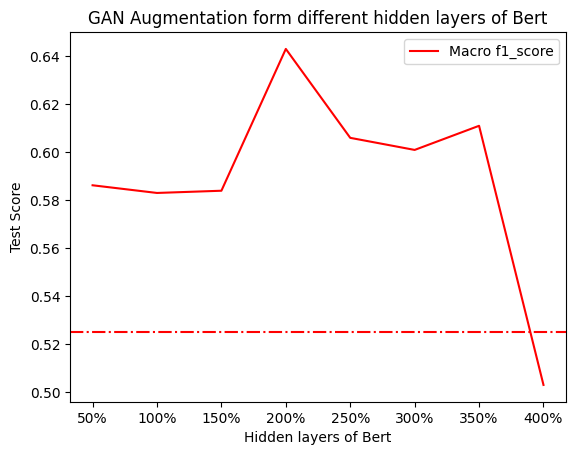

In [ ]:
x_label=["50%","100%","150%","200%","250%","300%","350%","400%"]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(F1s, label="Macro f1_score",color='r')
# plt.plot(Precisions, label="Macro precision",color='y')
# plt.plot(Recalls, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(8)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [ ]:
print(F1s)

In [ ]:
value_counts = train_df[label_column].value_counts()
all_fls=np.array(Label_f1s)
for i in range(prd.num_class):
    label=label_encoder.inverse_transform([i])
    print(list(all_fls[:,i]))
    print(value_counts[label])

[0.8181818181818182, 0.7826086956521738, 0.8, 0.8333333333333334, 0.8064516129032259, 0.7397260273972602, 0.7575757575757577, 0.44827586206896547]
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen    970
Name: afdeling, dtype: int64
[0.3448275862068966, 0.3076923076923077, 0.3516483516483517, 0.3652173913043478, 0.3908045977011494, 0.46341463414634143, 0.4473684210526315, 0.3619047619047619]
Bedrijfsmachines    739
Name: afdeling, dtype: int64
[0.7777777777777777, 0.7777777777777777, 0.8135593220338982, 0.8275862068965518, 0.8214285714285715, 0.8070175438596491, 0.0, 0.7169811320754716]
Chemische producten    167
Name: afdeling, dtype: int64
[0.7142857142857142, 0.7719298245614035, 0.7200000000000001, 0.7241379310344827, 0.5915492957746479, 0.7017543859649122, 0.7272727272727272, 0.5970149253731343]
Cultuur-, sport- en recreatiediensten    400
Name: afdeling, dtype: int64
[0.8070175438596491, 0.8571428571428571, 0.8275862068965518, 0.8363636363636363, 0.7868852459016

In [ ]:
all_fls

array([[0.81818182, 0.34482759, 0.77777778, 0.71428571, 0.80701754,
        0.77142857, 0.62295082, 0.83018868, 0.68493151, 0.72413793,
        0.        , 0.88888889, 0.65714286, 0.66666667, 0.        ,
        0.        , 0.71428571, 0.65671642, 0.        , 0.68965517,
        0.58181818, 0.71186441, 0.        , 0.64864865, 0.86567164,
        0.67741935, 0.44660194, 0.67741935, 0.89552239, 0.71186441],
       [0.7826087 , 0.30769231, 0.77777778, 0.77192982, 0.85714286,
        0.74285714, 0.62686567, 0.84615385, 0.68      , 0.63013699,
        0.        , 0.87719298, 0.53333333, 0.68656716, 0.        ,
        0.        , 0.69444444, 0.58823529, 0.        , 0.61764706,
        0.52173913, 0.64615385, 0.22857143, 0.63768116, 0.88888889,
        0.78571429, 0.4742268 , 0.66666667, 0.89552239, 0.72413793],
       [0.8       , 0.35164835, 0.81355932, 0.72      , 0.82758621,
        0.7761194 , 0.59459459, 0.80645161, 0.65384615, 0.70588235,
        0.21276596, 0.80597015, 0.44776119, 0.

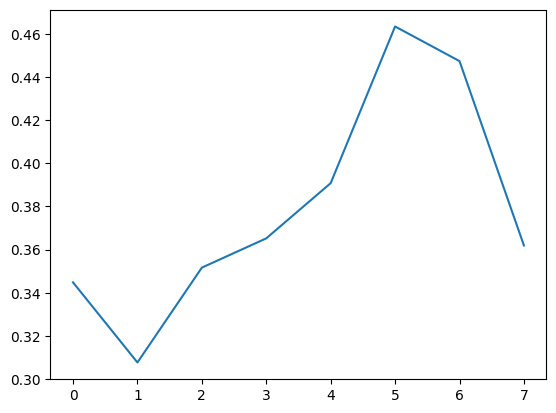

In [ ]:
plt.plot([0.3448275862068966, 0.3076923076923077, 0.3516483516483517, 0.3652173913043478, 0.3908045977011494, 0.46341463414634143, 0.4473684210526315, 0.3619047619047619]
)

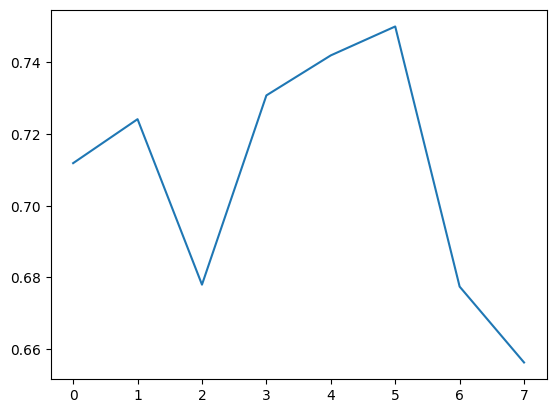

In [ ]:
plt.plot([0.711864406779661, 0.7241379310344827, 0.6779661016949153, 0.7307692307692307, 0.7419354838709677, 0.75, 0.6774193548387096, 0.65625]
)